In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.metrics import roc_curve, precision_recall_curve, auc, average_precision_score
from scipy.stats import percentileofscore
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
dat = pd.read_table('predictions/probabilities.tsv')

/opt/mmayers/software/anaconda3/envs/integrate/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
dat.head(2)

,compound_id,compound_name,disease_id,disease_name,category,status,prior_prob,prediction,training_prediction,compound_percentile,disease_percentile,n_trials,status_trials,status_drugcentral
0,Q408524,cyclophosphamide,Q41861,hypertension,NaN,0,0.5185,0.001796,0.490993,0.993103,0.964563,0,0,0
1,Q408524,cyclophosphamide,Q221668,acute cystitis,NaN,0,0.4364,0.000143,0.058045,0.831075,0.937586,0,0,0


In [6]:
pkdb = pd.read_table('../validate/pkdb.tsv')
pkdb['status_pkdb'] = pkdb['category'].apply(lambda s: 1 if s=='DM' else 0)
pkdb.head()

,doid_id,drugbank_id,disease,drug,category,n_curators,n_resources,compound_id,disease_id,status_pkdb
0,DOID:10652,DB00843,Alzheimer's disease,Donepezil,DM,2,1,Q415081,Q11081,1
1,DOID:10652,DB00674,Alzheimer's disease,Galantamine,DM,1,4,Q412690,Q11081,1
2,DOID:10652,DB01043,Alzheimer's disease,Memantine,DM,1,3,Q412189,Q11081,1
3,DOID:10652,DB00989,Alzheimer's disease,Rivastigmine,DM,1,3,Q411887,Q11081,1
4,DOID:10652,DB00245,Alzheimer's disease,Benzatropine,SYM,3,1,Q415026,Q11081,0


In [7]:
dat = dat.merge(pkdb[['compound_id', 'disease_id', 'status_pkdb']], how='left')

dat['status_pkdb'] = dat['status_pkdb'].fillna(0).astype(int)
dat.head()

,compound_id,compound_name,disease_id,disease_name,category,status,prior_prob,prediction,training_prediction,compound_percentile,disease_percentile,n_trials,status_trials,status_drugcentral,status_pkdb
0,Q408524,cyclophosphamide,Q41861,hypertension,NaN,0,0.5185,0.001796,0.490993,0.993103,0.964563,0,0,0,0
1,Q408524,cyclophosphamide,Q221668,acute cystitis,NaN,0,0.4364,0.000143,0.058045,0.831075,0.937586,0,0,0,0
2,Q408524,cyclophosphamide,Q19000661,congestive heart failure,NaN,0,0.4185,0.001555,0.390032,0.990561,0.967307,0,0,0,0
3,Q408524,cyclophosphamide,Q19597369,Gram-negative bacterial infection,NaN,0,0.4103,0.000143,0.054283,0.831075,0.937357,0,0,0,0
4,Q412415,cisplatin,Q41861,hypertension,NaN,0,0.3942,0.000143,0.052054,0.876331,0.850937,0,0,0,0


In [8]:
# Ensure not testing against ones already known to be positive
idx = dat.query('status == 1').index
dat.loc[idx, 'status_pkdb'] = float('nan')

In [9]:
print('Training Positives:', dat['status'].fillna(0).sum())
print('PKDB Positives:', dat['status_pkdb'].fillna(0).sum())
print('Drugcentral Positives:', dat['status_drugcentral'].fillna(0).sum())
print('Trials Positives:', dat['status_trials'].fillna(0).sum())

Training Positives: 2969
PKDB Positives: 460.0
Drugcentral Positives: 121.0
Trials Positives: 5159.0


In [11]:
metrics = ['status', 'status_pkdb', 'status_drugcentral', 'status_trials']
auroc_results = defaultdict(dict)
name_map = {'status': 'Training Set', 'status_pkdb': 'PharmacotherapyDB', 
            'status_drugcentral': 'Drug Central', 'status_trials': 'Clinical Trials'}

for metric in metrics:

    df = dat[[metric, 'prediction']].dropna().sort_values('prediction')
    
    fpr, tpr, thresh = roc_curve(df[metric], df['prediction'])
    
    auroc_results[metric]['fpr'] = fpr
    auroc_results[metric]['tpr'] = tpr
    auroc_results[metric]['thresh'] = thresh
    auroc_results[metric]['auc'] = auc(fpr, tpr)
        

In [12]:
sns.set_style('whitegrid')

/opt/mmayers/software/anaconda3/envs/integrate/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


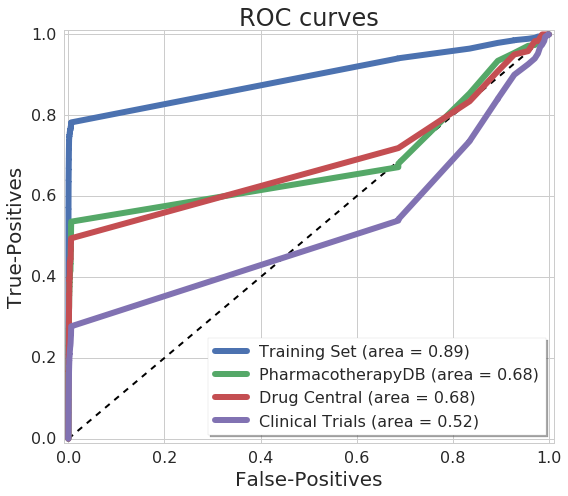

In [65]:
lw = 6

x = [i for i in np.arange(0.0,1.01,.01)]
plt.plot(x,x, 'k--', lw = lw-4)

for metric in metrics:
    plt.plot(auroc_results[metric]['fpr'], auroc_results[metric]['tpr'], lw=lw,
             label='{0} (area = {1:0.2f})'
                 .format(name_map[metric], auroc_results[metric]['auc']))

fig = plt.gcf()
fig.set_size_inches(8, 7)
fig.set_tight_layout(True)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xticks(size=16)
plt.yticks(size=16)
plt.xlabel('False-Positives', size=20)
plt.ylabel('True-Positives', size=20)
plt.title('ROC curves', size=24)
plt.legend(loc="lower right", frameon=True, shadow=True, prop={'size':16})
plt.savefig('figure/ROC-Curves.png', dpi=300)

In [33]:
pr_results = defaultdict(dict)


for metric in metrics:

    df = dat[[metric, 'prediction']].dropna().sort_values('prediction')
    
    pre, rec, thresh = precision_recall_curve(df[metric], df['prediction'])
    
    pr_results[metric]['pre'] = pre
    pr_results[metric]['rec'] = rec
    pr_results[metric]['thresh'] = thresh
    pr_results[metric]['avg'] = average_precision_score(df[metric], df['prediction'])
        

/opt/mmayers/software/anaconda3/envs/integrate/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


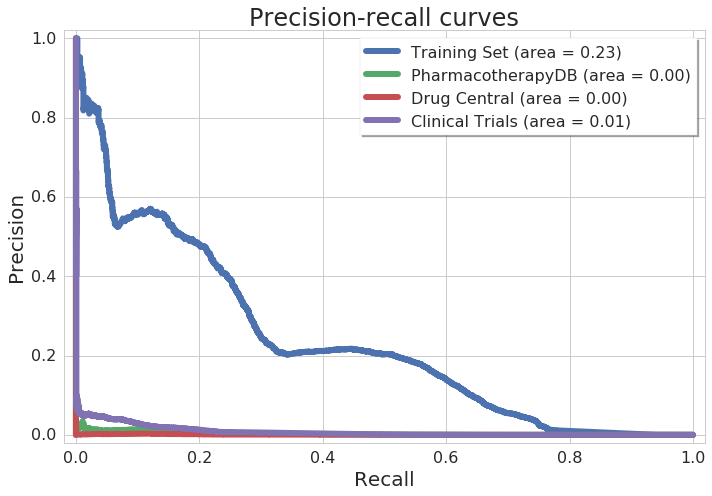

In [67]:
for metric in metrics:
    plt.plot(pr_results[metric]['rec'], pr_results[metric]['pre'], lw=lw,
             label='{0} (area = {1:0.2f})'
                 .format(name_map[metric], pr_results[metric]['avg']))

fig = plt.gcf()
fig.set_size_inches(10, 7)
fig.set_tight_layout(True)
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xticks(size=16)
plt.yticks(size=16)
plt.xlabel('Recall', size=20)
plt.ylabel('Precision', size=20)
plt.title('Precision-recall curves', size=24)
plt.legend(loc="upper right", frameon=True, shadow=True, prop={'size':16})
plt.savefig('figure/PR-Curves.png', dpi=300)

In [51]:
# Get all the predicitons
prediction = sorted(dat['prediction'].values)

In [50]:
# Get the ~9000 that have a status of 1 so we don't have to caluclate on 36 Million
sub_dat = dat[(dat[metrics] == 1).T.sum() > 0].reset_index(drop=True)

In [85]:
n = len(prediction)

In [87]:
def get_percentile(score):
    """Hack for quickly finding the percentile"""
    return (prediction.index(score) + 1) / len(prediction) * 100

In [88]:
#%%time
## This took 1h 48m 31s (tests showed about 1.2 seconds per calc by 8,344 calcs, so was a bit faster than tested)
#sub_dat['predictile'] = sub_dat['prediction'].apply(get_percentile)
#sub_dat.to_csv('predictions/predictile.tsv', sep='\t', index=False)

CPU times: user 1h 48min 31s, sys: 34.6 s, total: 1h 49min 5s
Wall time: 1h 49min 3s


Not going to run this again if I don't have to

In [69]:
# Load on future runthroughs
sub_dat = pd.read_table('predictions/predictile.tsv')

In [70]:
# Reshape the data for easy violin plotting
predictile = []
for metric in metrics:
    sub_df = sub_dat.query('{} == 1'.format(metric))['predictile'].reset_index(drop=True).to_frame()
    sub_df['metric'] = name_map[metric]
    predictile.append(sub_df)
predictile = pd.concat(predictile)

/opt/mmayers/software/anaconda3/envs/integrate/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


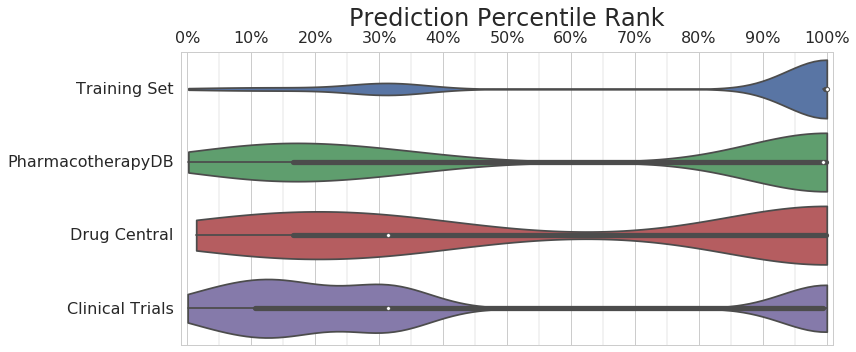

In [75]:
fig = sns.violinplot(x='predictile', y='metric', data=predictile, scale='width', cut=0)

fig = plt.gcf()
fig.set_size_inches(12, 5)
fig.set_tight_layout(True)
plt.xlabel('Prediction Percentile Rank', size = 24)
plt.yticks(size=16)
plt.xticks(np.arange(0, 101, 10))
plt.xlim(-1, 101)
plt.axes().set_xticklabels([str(x)+'%' for x in range(0, 101, 10)], size=16)
plt.axes().set_ylabel('')
plt.axes().xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(n=2))
plt.axes().xaxis.grid(b=True, which='minor', color='k', linewidth=0.1)
plt.axes().xaxis.tick_top()
plt.axes().xaxis.set_label_position('top')
plt.savefig('figure/predictile.png', dpi=300);